# Table of Contents
* [Introduction](#Introduction)
	* [Guiding questions](#Guiding-questions)
	* [Related notebooks](#Related-notebooks)
* [Setup](#Setup)
	* [Imports](#Imports)
	* [Load data](#Load-data)
* [Analysis](#Analysis)
* [Conclusions](#Conclusions)
	* [Key findings](#Key-findings)
	* [Next steps](#Next-steps)


# Introduction

This notebook is meant to reproduce the results reported on the alternate and regents table's in Nick's thesis

## Guiding questions

* Can I reproduce Nick's error distance results on the alternate set
* Can I get comparable groundtruth comparison for at least some of the Regents set

## Related notebooks

* **nicks_dataset**

<div class="alert alert-info"> Use this box for important points, reminders</div>

# Setup

## Imports

In [5]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import sklearn as sk
import scipy.stats as st
import itertools
import math
import hashlib
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [157]:
import os
import requests
import base64
import PIL.Image as Image
import cv2
import editdistance
from urllib.request import url2pathname

In [149]:
import ai2.vision.utils as ai2vu

In [20]:
%load_ext version_information
%reload_ext version_information
%version_information numpy, matplotlib, pandas, scipy, sklearn

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython 6.0.0
OS Darwin 16.6.0 x86_64 i386 64bit
numpy 1.12.1
matplotlib 2.0.2
pandas 0.20.1
scipy 0.19.0
sklearn 0.18.1
Wed May 31 11:18:39 2017 PDT

## Load data 

* **data files:table_ground_truth.json** 
* **Description of data: Version of Nick's dataset I was able to recover, clean, and consolidate** 

In [7]:
def compute_data_hash(data_path):
    with open(data_path, 'rb') as f:
        md5_hash = hashlib.md5(f.read()).hexdigest()
        print(data_path, md5_hash)
    return md5_hash

def compute_and_write_hashes(data_files, json_filename):
    data_hashes = {dfp: compute_data_hash(dfp) for dfp in data_files}
    output_dir = 'data_hashes'
    try:
        os.mkdir(output_dir)
    except FileExistsError:
        pass
    
    with open(os.path.join(output_dir, json_filename), 'w') as f:
        json.dump(data_hashes, f)

In [8]:
data_root_path = '/Users/schwenk/wrk/tableparse/data/test_data/'
data_file_1 = 'table_ground_truth.json'
data_path_1 = os.path.join(data_root_path, data_file_1)
data_file_paths = [data_path_1, ]

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var window_name = window.location.href;
var command = "notebook_url = \"" + escape(window_name) + "\""
kernel.execute(command);

<IPython.core.display.Javascript object>

In [10]:
nb_filename = url2pathname(notebook_url).split('/')[-1]
if nb_filename.endswith('#'):
    nb_filename = nb_filename[:-1]
json_filename = nb_filename.replace('ipynb', 'json')

compute_and_write_hashes(data_file_paths, json_filename)
print('on date:')
!date

/Users/schwenk/wrk/tableparse/data/test_data/table_ground_truth.json 706a02a205830cd85f743f60b1b13e6a
on date:
Wed May 31 11:18:11 PDT 2017


In [11]:
with open(data_path_1) as f:
    table_grountruth = json.load(f)

# Analysis

## Nick's reported results

B. Structural Evaluation To begin with, while working on the initial pieces of the
tool, we focused on evaluating structural components. This centered around the number of detected rows and columns. To accomplish this, we labeled the ground truth number of rows and columns for the Regents dataset, as well as a descriptor of the complexity of the image (three categories of difficulty). Comparing to these labels, following the switch from heuristic to classifier merging, we were successfully able to match the number of detected rows and columns for many of the images, including even some of the most complex category, which included non-table images. Overall, we were detecting 

the __correct number of columns for 89.5%__

the __correct number rows for 91.6%__

of rows correctly. With these results, we decided to switch and focus on a more robust metric of cell- level

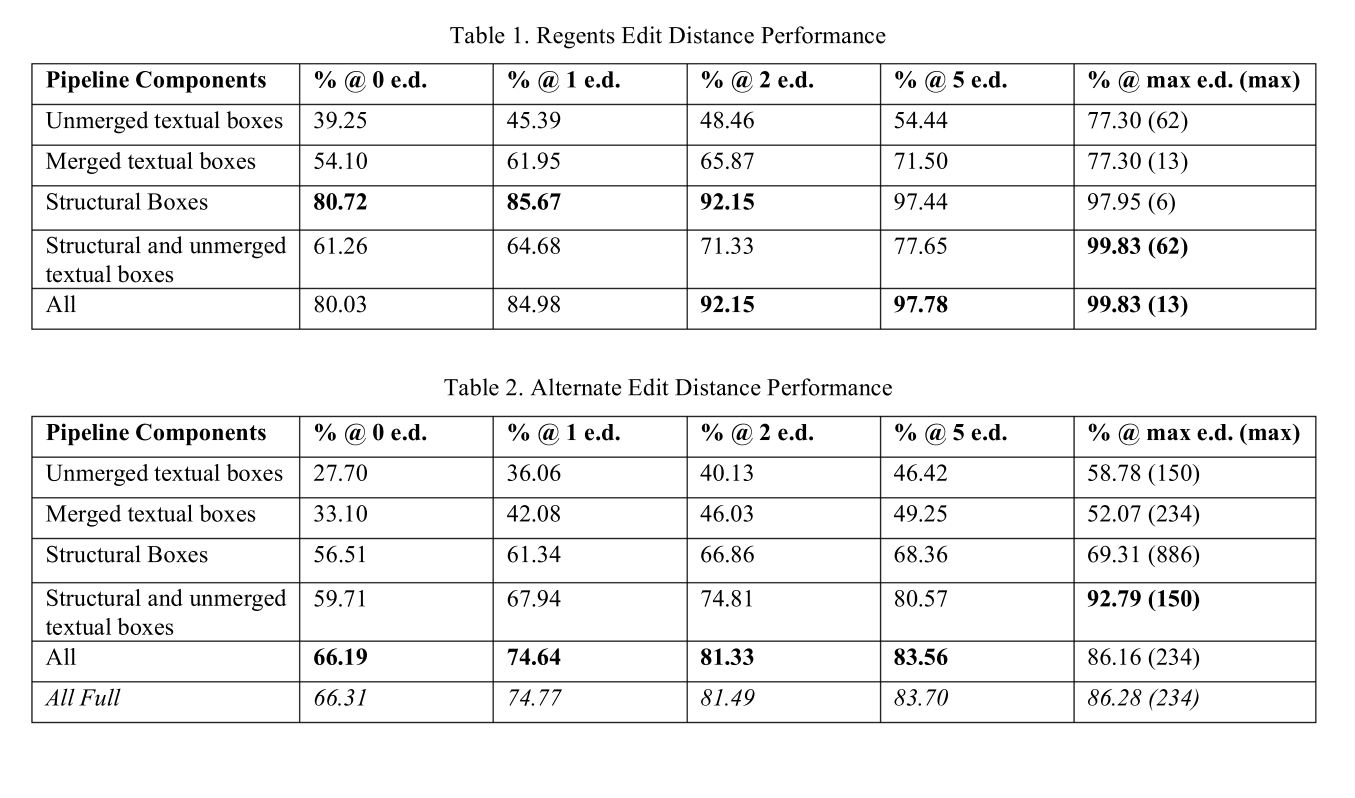

## Running Alternate through current pipeline

In [213]:
# api_entry_point = 'http://vision-tableparse.dev.allenai.org/v1/tableparse'
api_entry_point_local = 'http://127.0.0.1:5000/v1/tableparse'
header = {'Content-Type': 'application/json'}


def request_table_parse(image, rq_attr):
    request_data = {
        rq_attr: image.decode('utf-8'),
        'border_table': 'False'
    }
    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point_local, data=json_data, headers=header)
    json_response = json.loads(response.content.decode())
    if json_response:
        response = json_response
    return response


def parse_table_image(image_path):
    b64_encoded_image = base64.b64encode(open(image_path, 'rb').read())
    parser_response = request_table_parse(b64_encoded_image, 'image')
    return parser_response

In [210]:
image_base_path = '/Users/schwenk/wrk/tableparse/data/test_data/images'

In [215]:
table_parser_results = {}

first run 0-5, 6, 

In [316]:
start_idx = 5
end_idx = 6

In [317]:
for table_id, table_anno in list(table_grountruth.items())[start_idx:end_idx]:
    print(table_anno['imageName'])
    img_path = os.path.join(image_base_path, table_anno['imageName'])
    table_parser_results[table_id] = parse_table_image(img_path)

table_006.png


## cell-level agreement

In [315]:
def boxes_overlap(detected_box, gt_box, thresh=0.5):
    
    def area(box):
        return (box[3] - box[1]) * (box[2] - box[0])

    detected_coords = [[detected_box['rectangle'][n]['x'], detected_box['rectangle'][n]['y']] for n in range(2)]
    detected_coords = [item for sublist in detected_coords for item in sublist]
    gt_coords = gt_box['rectangle']
    gt_coords = gt_coords[:2] + list(map(np.add, gt_coords[:2], gt_coords[2:]))
    
    dx = min(detected_coords[2], gt_coords[2]) - max(detected_coords[0], gt_coords[0])
    dy = min(detected_coords[3], gt_coords[3]) - max(detected_coords[1], gt_coords[1])
    if (dx >= 0) and (dy >= 0):
        intersection_area = dx * dy
        return float(intersection_area) / min(area(detected_coords), area(gt_coords)) > thresh
    else:
        return False
    
    
def match_boxes(detected_boxes, gt_boxes, thresh=0.5):
    matches = []
    for db in detected_boxes:
        for gtb in gt_boxes:
            if boxes_overlap(db, gtb, thresh):
                matches.append((gtb['text'], db['value']))
    return matches


def compute_eds(matched_cell_contents):
    return [editdistance.eval(*cells) for cells in matched_cell_contents]


def compute_ed_scores(parsed_tables, gt_tables):
    ed_scores = {}
    for table_id in parsed_tables:
        detected_boxes = [item for sublist in parsed_tables[table_id]['columns'] for item in sublist]
        gt_boxes = gt_tables[table_id]['annotations']
        matched_cells = match_boxes(detected_boxes, gt_boxes, 0.5)
        eds = compute_eds(matched_cells)
        ed_scores[table_id] = eds
    return ed_scores


def compute_perf_table(error_distances):
    ed_array = np.array([item for sublist in list(error_distances.values()) for item in sublist])
    n_cells = ed_array.shape[0]
    perc_perf_at_eds = [sum(ed_array < n) / n_cells  * 100 for n in list(range(1, 6)) + [13]]
    perf_table = pd.DataFrame(perc_perf_at_eds).T
    perf_table.columns = ['% @ 0 e.d', '% @ 1 e.d', '% @ 2 e.d', '% @ 3 e.d', '% @ 4 e.d', '% @ max e.d. (13)']
    return perf_table

In [318]:
error_dists = compute_ed_scores(table_parser_results, table_grountruth)

## results

In [319]:
compute_perf_table(error_dists)

,% @ 0 e.d,% @ 1 e.d,% @ 2 e.d,% @ 3 e.d,% @ 4 e.d,% @ max e.d. (13)
0,55.932203,63.135593,80.084746,97.033898,97.881356,100.0


# Conclusions

## Key findings

* Key finding 1

## Next steps

* Next steps 1

## hide

In [218]:
# test_table = list(table_grountruth.values())[9]

# img_path = os.path.join(image_base_path, test_table['imageName'])

# test_response = parse_table_image(img_path)